In [1]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 2h,i,j,k

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import os
from collections import defaultdict

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from submanifolds.utils import get_root

### Functions

In [2]:
def sinusoidal_bump(N,amplitude,center,period,epsilon):
    bump = np.zeros(N)
    sinusoid = np.zeros(N)

    left_bound = int(N/2 - period/2)
    right_bound = int(N/2 + period/2)
    support = np.arange((left_bound+1),right_bound)

    x = np.arange(1,period)
    sine_bump = 0.5 - 0.5*np.cos(2*np.pi*x/period)
    sinusoid[support] = sine_bump
    
    bump[support] = sinusoid[support] * (1 + epsilon) / (sinusoid[support] + epsilon)
    if epsilon == 0:
        bump[left_bound] = 1

    bump = bump/np.max(bump)
    bump = amplitude*np.roll(bump, int(center - N/2))
    return bump

In [3]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def rect(x,a,x0,s):
    T = len(x)
    resp = np.zeros(T)
    resp[int(x0-s):int(x0+s)] = a
    return resp

### Set up directory to store figures

In [4]:
root = get_root()

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_2/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('exists')
    
save_figs_flag = 0

exists


### Color palettes

In [5]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

palette = ['#C47475', '#7F9CB0']

### Part IIc: Sparsity effect on manifold orientation
#### Produces Figure h,j,i,k

In [6]:
epsilon=10000
N = 1000
T = 1000

period = 600
n_periods = 1

n_subspaces = 10

perc_silenced = np.arange(0,1,.01)
n_perc_silenced = len(perc_silenced) 

modes = [1,2,3,4]
n_modes = len(modes)

x = np.arange(N)
dt = np.ones(T)
t0 = 500

amplitude = 1
x = np.arange(N)

R = np.zeros((n_subspaces, N, T))
dt = 1

In [7]:
_R = np.zeros((N,T))
w = sinusoidal_bump(N,amplitude,t0,period,epsilon)
for t in range(T):
    w = np.roll(w, dt)
    _R[:,t] = w

In [8]:
I = np.ones((n_perc_silenced, n_subspaces, N, 1), dtype='int')
R = np.zeros((n_perc_silenced, n_subspaces, N, T))

for perc_i, perc in enumerate(perc_silenced):
    for subspace_j in range(n_subspaces):
        inds = np.random.choice(N, int(perc*N), replace=False)
        I[perc_i,subspace_j,inds] = 0
        R[perc_i,subspace_j,:,:] = I[perc_i,subspace_j,:] * _R

In [9]:
pca = defaultdict(dict)
n_components = 2 #int(n_modes*2)
# note exchanged N and T, transposed for PCA
R_centered = np.zeros((n_perc_silenced, n_subspaces, T, N))
for perc_i, perc in enumerate(perc_silenced):
    for subspace_j in range(n_subspaces):
        # center the data
        R_centered[perc_i,subspace_j,:,:] = StandardScaler().fit_transform(R[perc_i,subspace_j,:,:].T)
    
        # compute PCA
        pca[perc_i,subspace_j] = decomposition.PCA(n_components=n_components)
        pca[perc_i,subspace_j].fit(R_centered[perc_i,subspace_j,:,:])

In [10]:
proj = defaultdict(dict)
radius = np.zeros((n_perc_silenced, n_subspaces, n_modes, 2))
for perc_i, perc in enumerate(perc_silenced):
    for subspace_j in range(n_subspaces):
        proj[perc_i, subspace_j] = np.dot(pca[perc_i,subspace_j].components_, R_centered[perc_i,subspace_j,:,:].T)

In [11]:
angles = np.zeros((n_perc_silenced, int(n_subspaces*(n_subspaces-1)/2), n_components))
angles_mean = np.zeros((n_perc_silenced, n_components))
angles_std = np.zeros((n_perc_silenced, n_components))

for k, p in enumerate(perc_silenced):
    count = 0
    for j in range(n_subspaces):
        for l in range(j+1, n_subspaces):
            u, s, vh = np.linalg.svd(np.dot(pca[k,j].components_, pca[k,l].components_.T), full_matrices=True)
            angles[k, count, :] = np.arccos(np.clip(s, -1, 1))*180/np.pi
            count += 1

angles_mean = angles.mean(axis=1)
angles_std = angles.std(axis=1)

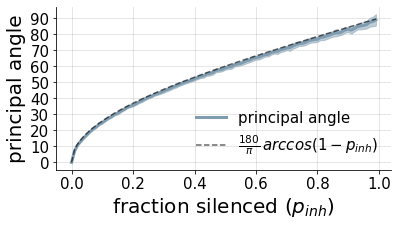

In [12]:
fname = 'angle_vs_fraction_silenced.pdf'
ind = 0
palette = ['#C47475', '#7F9CB0'] 
ticksize = 15
labelsize = 15

fig, ax = plt.subplots(figsize=(6,3))
plt.plot(perc_silenced, angles_mean[:,ind], color=palette[1], linewidth=3, label='principal angle')
plt.fill_between(perc_silenced, 
                 angles_mean[:,ind]-angles_std[:,ind], 
                 angles_mean[:,ind]+angles_std[:,ind], color=palette[1], alpha=0.5)

plt.plot(perc_silenced, np.arccos(1-perc_silenced)*180/np.pi, color='black', linestyle='--', alpha=0.6, label='$\\frac{180}{\pi} \, arccos(1-p_{inh})$')

# formatting plot
plt.xlabel('fraction silenced ($p_{inh}$)', fontsize=20)
plt.ylabel('principal angle', fontsize=20)
plt.xticks(np.arange(0,1.1,0.2), fontsize=17)
plt.yticks(np.arange(0,100,10), fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(alpha=0.4)
plt.legend(fontsize=labelsize, frameon=False)

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

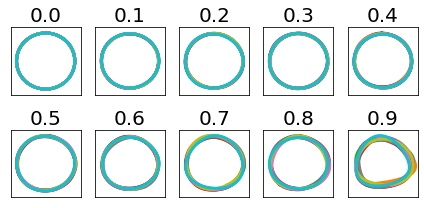

In [13]:
fname = 'example_trajectories_pc_space.pdf'
n_row = 2
n_col = 5
inds = np.arange(0,100,10)
perc_silenced_sel = perc_silenced[inds]
fig, ax = plt.subplots(n_row, n_col, figsize=(6, 3))
for i, perc in enumerate(perc_silenced_sel):
    ii = i % n_col
    jj = i // n_col
    for j in range(n_subspaces):
        ax[jj, ii].plot(*proj[inds[i],j], linewidth=3) #, marker='.')
    ax[jj, ii].set_title(perc.round(2), fontsize=20)
    window = 1.2*np.max(proj[inds[i],j])
    ax[jj, ii].set_xlim(-window,window)
    ax[jj, ii].set_ylim(-window,window)
    ax[jj, ii].set_xticks([])
    ax[jj, ii].set_yticks([])
fig.tight_layout() 
if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

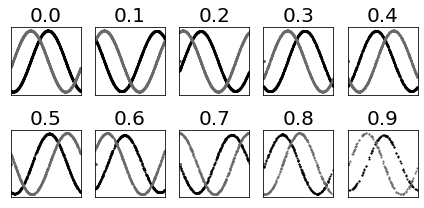

In [14]:
fname = 'principal_components.pdf'
n_row = 2
n_col = 5
inds = np.arange(0,100,10)
perc_silenced_sel = perc_silenced[inds]
fig, ax = plt.subplots(n_row, n_col, figsize=(6, 3))
for i, perc in enumerate(perc_silenced_sel):
    ii = i % n_col
    jj = i // n_col
    pc1 = pca[inds[i],0].components_[0,:].T
    pc2 = pca[inds[i],0].components_[1,:].T
    ax[jj, ii].plot(x[pc1!=0], pc1[pc1!=0], marker='.', markersize=2, linestyle='', color='black')
    ax[jj, ii].plot(x[pc2!=0], pc2[pc2!=0], marker='.', markersize=2, linestyle='', color='dimgray')
    ax[jj, ii].set_title(perc.round(2), fontsize=20)
    ax[jj, ii].set_xlim(0,1000)
    ax[jj, ii].set_xticks([])
    ax[jj, ii].set_yticks([])
fig.tight_layout() 

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()

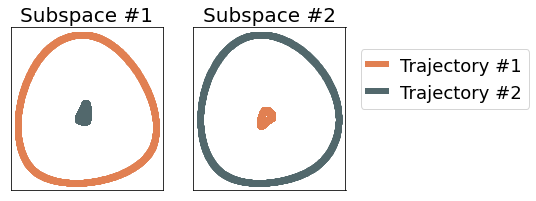

In [15]:
fname = 'subspace_projections.pdf'
perc_i = np.where(perc_silenced == 0.92)[0][0]
subspace_j = 0
subspace_k = 1

subspace_j_into_k = np.dot(pca[perc_i,subspace_k].components_, R_centered[perc_i,subspace_j,:,:].T)
subspace_k_into_j = np.dot(pca[perc_i,subspace_j].components_, R_centered[perc_i,subspace_k,:,:].T)

fig, ax = plt.subplots(1,2,figsize=(6,3))

ax[0].scatter(*proj[perc_i, subspace_j], color='#E18052')
ax[0].scatter(*subspace_k_into_j, color='#52686C')


ax[1].scatter(*subspace_j_into_k, color='#E18052')
ax[1].plot([],[], linewidth=6, color='#E18052', label='Trajectory #1')
ax[1].scatter(*proj[perc_i, subspace_k], color='#52686C')
ax[1].plot([],[], linewidth=6, color='#52686C', label='Trajectory #2')

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_title('Subspace #1', fontsize=20)
ax[1].set_title('Subspace #2', fontsize=20)
ax[1].legend(loc=[1.1,0.5], fontsize=18, handlelength=1)

if save_figs_flag:
    plt.savefig(fig_dir+fname, bbox_inches="tight")
plt.show()